In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics

import sys
sys.path.insert(1, '../src/stproject')
from utils import *

import pickle

In [3]:
# importing feature-engineered dataset v1 (df_fe1.csv)

df_fe0 = pd.read_csv('../data/df_fe0.csv', index_col=0)

# computing new feature: molar volume (mv = M/density)
df_fe0['mv'] = df_fe0['M']/df_fe0['density']
print(len(df_fe0))
df_fe0.head()

268


C     H  C=C  C#C   Ar  O-alc  O-eth  O-ald  O-ket  O-acid  ...   R4  \
1  5.0  12.0  0.0  0.0  0.0    0.0    0.0    0.0    0.0     0.0  ...  0.0   
2  6.0  14.0  0.0  0.0  0.0    0.0    0.0    0.0    0.0     0.0  ...  0.0   
3  7.0  16.0  0.0  0.0  0.0    0.0    0.0    0.0    0.0     0.0  ...  0.0   
4  8.0  18.0  0.0  0.0  0.0    0.0    0.0    0.0    0.0     0.0  ...  0.0   
5  9.0  20.0  0.0  0.0  0.0    0.0    0.0    0.0    0.0     0.0  ...  0.0   

    R5   R6   R7   R8        M  measured_st  molecule  density          mv  
1  0.0  0.0  0.0  0.0   72.151         15.5   Pentane  0.62638  115.187267  
2  0.0  0.0  0.0  0.0   86.178         18.0    Hexane  0.65940  130.691538  
3  0.0  0.0  0.0  0.0  100.205         19.8   Heptane  0.68420  146.455715  
4  0.0  0.0  0.0  0.0  114.232         21.1    Octane  0.70310  162.469066  
5  0.0  0.0  0.0  0.0  128.259         22.4    Nonane  0.71760  178.733278  

[5 rows x 22 columns]

## Linear model for mv

In [47]:
# exclusion of samples with certain motifs due to lack of datapoints and/or irrelevance to polyester
features_exclude = ['C#C', 'R3', 'R4', 'R7', 'R8', 'O-alc', 'O-ald', 'O-acid', 'O-ket']
df_fe0 = df_fe0[df_fe0[features_exclude].sum(axis=1) == 0]
len(df_fe0)

185

In [48]:
st = df_fe0['measured_st']
mv = df_fe0['mv']

In [49]:
X_mv = df_fe0.drop(['M', 'measured_st', 'molecule', 'density', 'mv']+features_exclude, axis=1)

lm_mv = LinearRegression()
lm_mv.fit(X_mv, mv)

mv_hat = lm_mv.predict(X_mv)
regression_results(mv, mv_hat)
coef_mv = (pd.DataFrame({'var': ['intercept']+X_mv.columns.tolist(), 'coef': [lm_mv.intercept_]+list(lm_mv.coef_)}))

mv_hat = lm_mv.predict(X_mv)
print(coef_mv)

explained_variance:  0.9991
mean_squared_log_error:  0.0003
r2:  0.9991
MAE:  1.7604
MSE:  6.4838
RMSE:  2.5463
         var       coef
0  intercept  18.266681
1          C   6.034034
2          H   5.271587
3        C=C   2.980169
4         Ar   2.786611
5      O-eth   6.045582
6    O-ester   7.245555
7         R5  -5.687757
8         R6  -8.663393


Text(0.5, 1.0, 'Linear Model - mv')

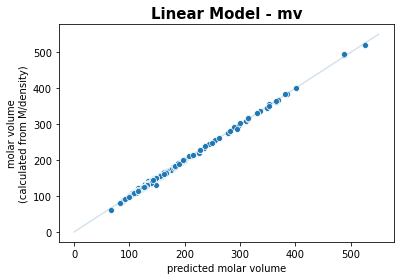

In [100]:
sns.scatterplot(mv_hat, mv)
sns.lineplot(x=[0, 550], y=[0, 550], alpha=0.2)
plt.xlabel('predicted molar volume')
plt.ylabel('molar volume\n(calculated from M/density)')
plt.title('Linear Model - mv', {'fontsize': 15, 'weight': 'bold'})

### Linear model 0 - parachor model

In this model, surface tension (gamma) is expressed as gamma = (P/mv)^n, with <br> 
mv = M/density <br>
n = power (value of 4 is suggested by literatures)

In [137]:
n = 4
X0 = df_fe0.drop(['M', 'measured_st', 'molecule', 'density', 'mv']+features_exclude, axis=1)
y0 = (st**(1/n)) * mv

In [146]:
lm0 = LinearRegression()
lm0.fit(X0, y0)
y_hat0 = lm0.predict(X0)
st_hat0 = (y_hat0/mv)**n

regression_results(st, st_hat0)
coef0 = (pd.DataFrame({'var': ['intercept']+X0.columns.tolist(), 'coef': [lm0.intercept_]+list(lm0.coef_)}))
print(coef0)

with open('../models/lm0.pickle','wb') as modelFile:
    pickle.dump(lm0,modelFile)

explained_variance:  0.8712
mean_squared_log_error:  0.0028
r2:  0.8712
MAE:  0.8753
MSE:  2.325
RMSE:  1.5248
         var       coef
0  intercept  18.099149
1          C  21.415582
2          H   8.765918
3        C=C   6.990393
4         Ar   5.348100
5      O-eth  20.095641
6    O-ester  20.193352
7         R5  -8.798219
8         R6 -12.648627


In [152]:
# points with highest error (in descending order)
i_out0 = abs(st-st_hat0).sort_values(ascending=False).index[:5]
st_out0 = st[i_out0]
st_hat_out0 = st_hat0[i_out0]
df_fe0.loc[i_out0, ['molecule', 'measured_st', 'density', 'mv']]

molecule  measured_st  density          mv
186                    Hexyl formate         26.4   0.9900  131.502020
192                   Propyl acetate         23.8   0.8360  122.168660
53            1,2,3-Trimethylbenzene         28.3   0.8944  134.386181
283  2,2,4,4,6,8,8-Heptamethylnonane         24.2   0.7930  285.558638
235                 Methyl palmitate         29.6   0.8520  317.437793

Text(0.5, 1.0, 'Linear Model 0\nParachor')

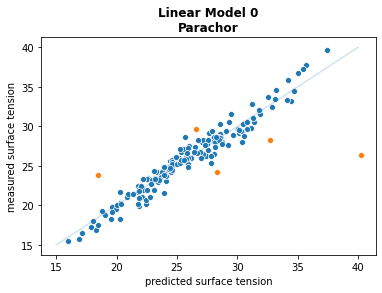

In [154]:
sns.scatterplot(st_hat0, st)
sns.scatterplot(st_hat_out0, st_out0)
sns.lineplot(x=[15, 40], y=[15, 40], alpha=0.2)
plt.xlabel('predicted surface tension')
plt.ylabel('measured surface tension')
plt.title('Linear Model 0\nParachor', {'fontsize': 12, 'weight': 'bold'})

### Linear model 1 - with features (molecular fragments) normalized by M

In this model, only molecular fragments normalized (divided) by M are used as regressors.

In [54]:
X1 = (df_fe0.drop(['M', 'measured_st', 'molecule', 'density', 'mv']+features_exclude, axis=1)
                   .divide(df_fe0['M'], axis=0))
X1.head()

C         H  C=C   Ar  O-eth  O-ester   R5   R6
1  0.069299  0.166318  0.0  0.0    0.0      0.0  0.0  0.0
2  0.069623  0.162454  0.0  0.0    0.0      0.0  0.0  0.0
3  0.069857  0.159673  0.0  0.0    0.0      0.0  0.0  0.0
4  0.070033  0.157574  0.0  0.0    0.0      0.0  0.0  0.0
5  0.070171  0.155934  0.0  0.0    0.0      0.0  0.0  0.0

In [55]:
lm1 = LinearRegression()
lm1.fit(X1, st)
y1_hat = lm1.predict(X1)

regression_results(st, y1_hat)
coef1 = (pd.DataFrame({'var': ['intercept']+X1.columns.tolist(), 'coef': [lm1.intercept_]+list(lm1.coef_)}))
print(coef1)

with open('../models/lm1.pickle','wb') as modelFile:
    pickle.dump(lm1,modelFile)

explained_variance:  0.8611
mean_squared_log_error:  0.0036
r2:  0.8582
MAE:  1.2032
MSE:  2.5606
RMSE:  1.6002
         var          coef
0  intercept -1.442167e+15
1          C  1.732186e+16
2          H  1.453704e+15
3        C=C -1.018702e+03
4         Ar -3.691845e+03
5      O-eth  2.307322e+16
6    O-ester  2.307322e+16
7         R5 -6.617434e+02
8         R6 -5.714224e+02


Text(0.5, 1.0, 'Linear Model 2\nM-normalized fragments')

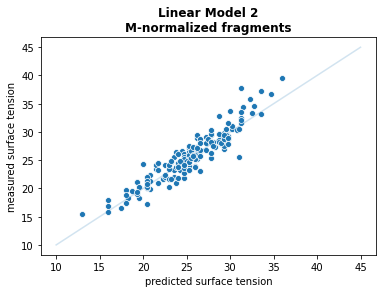

In [109]:
sns.scatterplot(y1_hat, st)
sns.lineplot(x=[10, 45], y=[10, 45], alpha=0.2)
plt.xlabel('predicted surface tension')
plt.ylabel('measured surface tension')
plt.title('Linear Model 2\nM-normalized fragments', {'fontsize': 12, 'weight': 'bold'})

# Preparation of test set

In [64]:
df_test = pd.read_csv('../data/polyesters.csv')
df_diols_fe0 = pd.read_csv('../data/df_diols_fe0.csv', index_col=0)
df_acids_fe0 = pd.read_csv('../data/df_acids_fe0.csv', index_col=0)

# correcting 'H', O-alc', 'O-acid' and 'O-ester' by subtracting atom/functional group loss from condensation
# TODO: make a function for this procedure
df_diols_fe0['H'] -= 2
df_acids_fe0['H'] -= 2
df_diols_fe0['O-alc'] -= 2
df_acids_fe0['O-acid'] -= 4
df_acids_fe0['O-ester'] += 4

df_monomers_fe0 = pd.concat([df_diols_fe0, df_acids_fe0])
df_monomers_fe0

C     H  C=C  C#C   Ar  O-alc  O-eth  O-ald  O-ket  O-acid  \
diol_1   12.0  18.0  0.0  0.0  0.0    0.0    0.0    0.0    0.0     0.0   
diol_2    8.0  14.0  0.0  0.0  0.0    0.0    0.0    0.0    0.0     0.0   
diol_3   15.0  26.0  0.0  0.0  0.0    0.0    0.0    0.0    0.0     0.0   
diol_4    9.0  18.0  0.0  0.0  0.0    0.0    0.0    0.0    0.0     0.0   
diol_5    8.0  16.0  0.0  0.0  0.0    0.0    0.0    0.0    0.0     0.0   
diol_7    5.0  10.0  0.0  0.0  0.0    0.0    0.0    0.0    0.0     0.0   
diol_8   14.0  24.0  0.0  1.0  0.0    0.0    0.0    0.0    0.0     0.0   
diol_9   14.0  24.0  0.0  1.0  0.0    0.0    0.0    0.0    0.0     0.0   
diol_10   5.0  10.0  0.0  0.0  0.0    3.0    0.0    0.0    0.0     0.0   
diol_11   6.0  10.0  0.0  0.0  0.0    0.0    0.0    0.0    0.0     0.0   
diol_12   9.0  18.0  0.0  0.0  0.0    0.0    0.0    0.0    0.0     0.0   
diol_14   3.0   6.0  0.0  0.0  0.0    0.0    0.0    0.0    0.0     0.0   
acid_1    4.0   2.0  1.0  0.0  0.0    0.0    0.0    0.0    0.0     0.0   
acid_2    6.0   8.0  0.0  0.0  0.0    0.0    0.0    0.0    0.0     0.0   
acid_3    8.0   4.0  0.0  0.0  1.0    0.0    0.0    0.0    0.0     0.0   
acid_4    9.0  12.0  0.0  0.0  0.0    0.0    0.0    0.0    0.0     0.0   
acid_5    8.0  10.0  0.0  0.0  0.0    0.0    0.0    0.0    0.0     0.0   
acid_6    5.0   4.0  1.0  0.0  0.0    0.0    0.0    0.0    0.0     0.0   
acid_7    6.0   6.0  0.0  0.0  0.0    1.0    0.0    0.0    0.0     2.0   
acid_8    9.0   4.0  0.0  0.0  1.0    0.0    0.0    0.0    0.0     2.0   
acid_9    8.0   4.0  0.0  0.0  1.0    0.0    0.0    0.0    0.0     0.0   

         O-ester   R3   R4   R5   R6   R7   R8        M  
diol_1       0.0  0.0  0.0  3.0  0.0  0.0  0.0  196.290  
diol_2       0.0  0.0  0.0  0.0  1.0  0.0  0.0  144.214  
diol_3       0.0  0.0  0.0  0.0  2.0  0.0  0.0  240.387  
diol_4       0.0  0.0  0.0  0.0  0.0  0.0  0.0  160.257  
diol_5       0.0  0.0  0.0  0.0  0.0  0.0  0.0  146.230  
diol_7       0.0  0.0  0.0  0.0  0.0  0.0  0.0  104.149  
diol_8       0.0  0.0  0.0  0.0  0.0  0.0  0.0  226.360  
diol_9       0.0  0.0  0.0  0.0  0.0  0.0  0.0  226.360  
diol_10      0.0  0.0  0.0  0.0  0.0  0.0  0.0  152.146  
diol_11      0.0  0.0  0.0  0.0  1.0  0.0  0.0  116.160  
diol_12      0.0  0.0  0.0  0.0  0.0  0.0  0.0  160.257  
diol_14      0.0  0.0  0.0  0.0  0.0  0.0  0.0   76.095  
acid_1       4.0  0.0  0.0  0.0  0.0  0.0  0.0  116.072  
acid_2       4.0  0.0  0.0  0.0  0.0  0.0  0.0  146.142  
acid_3       4.0  0.0  0.0  0.0  0.0  0.0  0.0  166.132  
acid_4       4.0  0.0  0.0  0.0  1.0  0.0  0.0  186.207  
acid_5       4.0  0.0  0.0  0.0  1.0  0.0  0.0  172.180  
acid_6       4.0  0.0  0.0  0.0  0.0  0.0  0.0  130.099  
acid_7       4.0  0.0  0.0  0.0  0.0  0.0  0.0  192.123  
acid_8       4.0  0.0  0.0  0.0  0.0  0.0  0.0  210.141  
acid_9       4.0  0.0  0.0  0.0  0.0  0.0  0.0  166.132

In [65]:
monomers = df_test.columns[df_test.columns.str.contains('diol|acid')]
features = df_monomers_fe0.columns

In [66]:
df_test_fe0 = avg_monomer_features(df_test, df_monomers_fe0, monomers, features)
print(df_test_fe0)
st_test = df_test['measured_st']

         C       H    C=C  C#C     Ar  O-alc  O-eth  O-ald  O-ket  O-acid  \
0    7.206   9.128  0.149  0.0  0.249    0.0    0.0    0.0    0.0   0.000   
1   10.749  15.212  0.149  0.0  0.248    0.0    0.0    0.0    0.0   0.000   
2   10.238  16.178  0.149  0.0  0.000    0.0    0.0    0.0    0.0   0.000   
3   10.131  15.776  0.243  0.0  0.000    0.0    0.0    0.0    0.0   0.000   
4    7.037  11.620  0.245  0.0  0.000    0.0    0.0    0.0    0.0   0.000   
5    6.528  10.602  0.245  0.0  0.000    0.0    0.0    0.0    0.0   0.000   
6    5.001   7.538  0.246  0.0  0.000    0.0    0.0    0.0    0.0   0.000   
7    6.540   9.630  0.242  0.0  0.000    0.0    0.0    0.0    0.0   0.000   
8    6.520   9.560  0.247  0.0  0.000    0.0    0.0    0.0    0.0   0.000   
9    6.118   8.364  0.444  0.0  0.000    0.0    0.0    0.0    0.0   0.000   
10   4.603   6.334  0.446  0.0  0.000    0.0    0.0    0.0    0.0   0.000   
11   8.544  11.586  0.246  0.0  0.000    0.0    0.0    0.0    0.0   0.000   

### TEST 0 - Prediction with parachor method

In [67]:
X_test0 = df_test_fe0[df_test_fe0.columns.difference(['M']+features_exclude)]
mv_hat_test0 = lm_mv.predict(X_test0)
mv_hat_test0
y_hat_test0 = lm0.predict(X_test0)
(y_hat_test0/mv_hat_test0)**n

array([12.03455145, 11.81531693, 11.42981776, 11.40622805, 11.08753739,
       11.13028412, 11.31829605, 11.44421772, 11.53186445, 11.65907188,
       11.47059154, 11.37010718, 11.37010718, 11.89648433, 10.99468402,
       11.54136187, 11.98715467, 11.88977426, 11.19826287])

Text(0.5, 1.0, 'Linear Model 0\nTest')

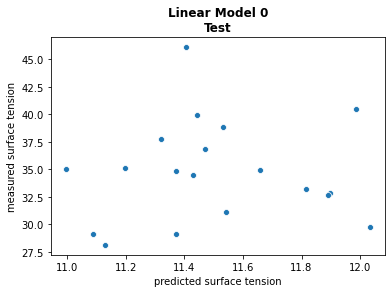

In [68]:
sns.scatterplot((y_hat_test0/mv_hat_test0)**n, st_test)
plt.xlabel('predicted surface tension')
plt.ylabel('measured surface tension')
plt.title('Linear Model 0\nTest', {'fontsize': 12, 'weight': 'bold'})

### TEST 1 - Prediction with M-normalization method

In [69]:
X_test1 = (df_test_fe0[df_test_fe0.columns.difference(['M']+features_exclude)]
           .divide(df_test_fe0['M']-18, axis=0))
y_hat_test1 = lm1.predict(X_test1)
y_hat_test1

array([-9.67047684e+14, -1.06963688e+15, -1.08776185e+15, -1.08944664e+15,
       -1.00807949e+15, -9.88551738e+14, -9.11567613e+14, -9.89658537e+14,
       -9.83006581e+14, -9.63636374e+14, -8.82137070e+14, -1.04614490e+15,
       -1.04614490e+15, -1.02825344e+15, -1.07840268e+15, -9.73190508e+14,
       -8.27236174e+14, -1.01040809e+15, -1.07098374e+15])

Text(0.5, 1.0, 'Linear Model 1\nTest')

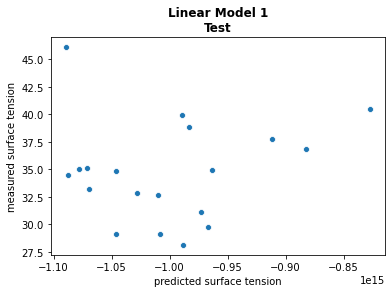

In [70]:
sns.scatterplot(y_hat_test1, st_test)
plt.xlabel('predicted surface tension')
plt.ylabel('measured surface tension')
plt.title('Linear Model 1\nTest', {'fontsize': 12, 'weight': 'bold'})

### Linear model - mv2

Approximation of molar volume with **polymer** data from literature

In [83]:
df_mvpolym_fe0 = pd.read_csv('../data/df_mvpolym_fe0.csv', index_col=0)
len(df_mvpolym_fe0)

23

In [158]:
features_exclude_from_mv = features_exclude + ['R5', 'R6']
df_mvpolym_fe0 = df_mvpolym_fe0[df_mvpolym_fe0[features_exclude_from_mv].sum(axis=1) == 0]

X_mvpolym = df_mvpolym_fe0.drop(['M', 'type', 'polymer', 'measured_mv', 'measured_mv_scaled', 'ru']+features_exclude_from_mv, axis=1)
y_mvpolym = df_mvpolym_fe0['measured_mv_scaled']
lm_mvpolym = LinearRegression()
lm_mvpolym.fit(X_mvpolym, y_mvpolym)

y_hat_mvpolym = pd.Series(lm_mvpolym.predict(X_mvpolym), index=y_mvpolym.index)
regression_results(y_mvpolym, y_hat_mvpolym)

explained_variance:  0.9426
mean_squared_log_error:  0.1764
r2:  0.9426
MAE:  8.2232
MSE:  135.2354
RMSE:  11.6291


In [160]:
# points with highest error (in descending order)
i_out_mvpolym = abs(y_mvpolym-y_hat_mvpolym).sort_values(ascending=False).index[:5]
y_out_mvpolym = y_mvpolym[i_out_mvpolym]
y_hat_out_mvpolym = y_hat_mvpolym[i_out_mvpolym]
df_mvpolym_fe0.loc[i_out_mvpolym, ['polymer', 'measured_mv']]

polymer  measured_mv
14                poly(methyl methacrylate)         84.1
5                               polystyrene        100.0
6                     poly(4-methylstyrene)        125.2
22  poly(5-tridecylresorcinol isophthalate)        380.2
0                              polyethylene         34.6

Text(0.5, 1.0, 'Linear Model MV\nPolymers')

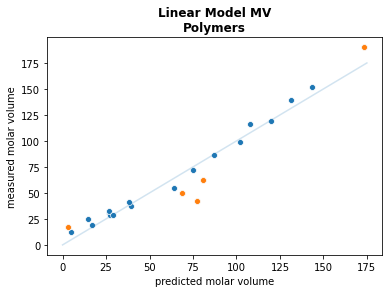

In [161]:
sns.scatterplot(y_hat_mvpolym, y_mvpolym)
sns.scatterplot(y_hat_out_mvpolym, y_out_mvpolym)
sns.lineplot(x=[0, 175], y=[0, 175], alpha=0.2)
plt.xlabel('predicted molar volume')
plt.ylabel('measured molar volume')
plt.title('Linear Model MV\nPolymers', {'fontsize': 12, 'weight': 'bold'})

In [92]:
X_mvpolym2 = df_mvpolym_fe0.drop(['M', 'type', 'polymer', 'measured_mv', 'measured_mv_scaled', 'ru']+features_exclude, axis=1)
y_hat_mvpolym2 = lm_mv.predict(X_mvpolym2)
regression_results(y_hat_mvpolym2, df_mvpolym_fe0['measured_mv_scaled'])

explained_variance:  0.6631
mean_squared_log_error:  0.5667
r2:  -0.2825
MAE:  36.7524
MSE:  1821.474
RMSE:  42.6787


In [93]:
X_mvpolym3 = (df_mvpolym_fe0[df_mvpolym_fe0['type'] == 'polyester']
              .drop(['M', 'type', 'polymer', 'measured_mv', 'measured_mv_scaled', 'ru']+features_exclude, axis=1))
y_hat_mvpolym3 = lm_mv.predict(X_mvpolym3)
regression_results(y_hat_mvpolym3, df_mvpolym_fe0.loc[df_mvpolym_fe0['type'] == 'polyester', 'measured_mv_scaled'])

explained_variance:  0.9794
mean_squared_log_error:  0.0109
r2:  0.8923
MAE:  11.1846
MSE:  146.7864
RMSE:  12.1155


Text(0.5, 1.0, 'Linear Model MV\nPolyesters only')

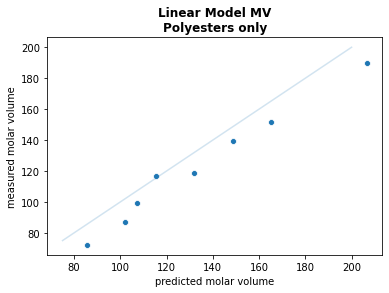

In [112]:
sns.scatterplot(y_hat_mvpolym3, df_mvpolym_fe0.loc[df_mvpolym_fe0['type'] == 'polyester', 'measured_mv_scaled'])
sns.lineplot(x=[75, 200], y=[75, 200], alpha=0.2)
plt.xlabel('predicted molar volume')
plt.ylabel('measured molar volume')
plt.title('Linear Model MV\nPolyesters only', {'fontsize': 12, 'weight': 'bold'})